In [0]:
### RUN THIS CELL ###
import torch
from torch.utils.data import DataLoader
from datetime import datetime
from torch.utils.data import random_split
from torch import nn
import numpy as np
from torch.optim.lr_scheduler import ExponentialLR
import time

In [2]:
### RUN THIS CELL ###
### ALSO UPLOAD THE RNN AND LSTM MODEL FILES NOW ###
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
### FUNCTIONS TO LOAD DATA FROM CHRIS'S THING (don't run this cell) ###
from CountyDataset import (
    CountyDataset,
)
def get_dataset(master_path):
    dataset = CountyDataset(master_path)
    X, Y = next(iter(dataset))

    print('-'*89)
    print('Total Dataset Summary')
    print('-'*89)

    print(f'total samples {len(dataset):,} '
          f'X {X.size()} | Y {Y.size()}')

    return dataset

def get_numpy(dataset):
    data = []
    for i in range(len(dataset)):
        X, Y = dataset[i]
        data.append((X.numpy(), Y.numpy()))

    print('-'*89)
    print(f'Numpy Dataset Summary')
    print('-'*89)
    X, Y = zip(*data)
    print(f'total samples {len(X)} '
          f'| input time periods {len(X[0])} '
          f'| input features {X[0].shape[1]} '
          f'| output time periods {len(Y[0])}'
          f'| target col {dataset.target_col}')

    return data, dataset.xcols, dataset.target_col, dataset.date_index



In [0]:
### LOAD DATASET FROM CHRIS'S THING (also don't run this cell) ###
master_path = 'utils/data/county_table.csv'
data = get_numpy(get_dataset(master_path))

# save data to pickle file
import pickle
with open('dataset.pickle', 'wb') as handle:
    pickle.dump(data[0], handle)

NameError: ignored

In [0]:
### RUN THIS CELL ###
### MAKE SURE YOU CHANGE THE NUM_MONTHS LINE AS NECESSARY ###
### LOAD DATA FROM PICKLE FILES ###
# change file paths to wherever the pickled data files are stored
import pickle
with open('drive/My Drive/DL project/datasets/test_24_1.pickle', 'rb') as handle:
    test_dataset = pickle.load(handle)
with open('drive/My Drive/DL project/datasets/train_24_1.pickle', 'rb') as handle:
    train_dataset = pickle.load(handle)
with open('drive/My Drive/DL project/datasets/val_24_1.pickle', 'rb') as handle:
    val_dataset = pickle.load(handle)

num_months = 24 ## change this line as necessary to the number of training months per instance

# this bit gets rid of all the incomplete series (i.e. those with less than num_months months)
train_dataset = [data for data in train_dataset if len(data[0]) == num_months]
test_dataset = [data for data in test_dataset if len(data[0]) == num_months]
val_dataset = [data for data in val_dataset if len(data[0]) == num_months]

In [25]:
### LINEAR REGRESSION ###
# perform linear regression on just the prices
x_train = np.array([data[0] for data in train_dataset])[:,:,-1]
y_train = np.array([data[1] for data in train_dataset])[:]

x_test = np.array([data[0] for data in test_dataset])[:,:,-1]
y_test = np.array([data[1] for data in test_dataset])[:]

# calculate explicit linear regression weights
weights = np.linalg.inv(x_train.T @ x_train) @ x_train.T @ y_train

# apply weights to test data to get predictions
y_test_pred = x_test @ weights

# calculate loss & MAPE
lrmse = np.sqrt(np.mean((y_test - y_test_pred) ** 2))
MAPE = np.mean(np.abs(np.exp(y_test) - np.exp(y_test_pred)) / np.exp(y_test)) * 100

# print an example prediction
print(np.exp(y_test_pred[83]), np.exp(y_test[83]))

print('LMRSE: {:.6f}\tMAPE: {:.3f}%'.format(lrmse, MAPE))

101258.27 153011.98
LMRSE: 0.595748	MAPE: 44.012%


In [0]:
### RUN THIS CELL ###
# make DataLoaders for each of the splits of the data
train_loader = DataLoader(train_dataset, batch_size=512,
                          shuffle=False, pin_memory=False,
                          num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1,
                          shuffle=False, pin_memory=False,
                          num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=512,
                          shuffle=False, pin_memory=False,
                          num_workers=4)

In [0]:
### RUN THIS CELL ###
### train, val, and test functions for main training loop ###
def train(model, train_loader, optimizer, loss_function, epoch, device=None):
    model.train()
    for idx, (X_train, y_train) in enumerate(train_loader):
        if device is not None:
            X_train, y_train = X_train.to(device), y_train.to(device)

        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = torch.sqrt(loss_function(y_pred, y_train)) # loss is RMSE of log prices
        loss.backward()
        optimizer.step()

    return loss.item()

def val(model, val_loader, loss_function, device=None):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for idx, (X_val, y_val) in enumerate(val_loader):
            if device is not None:
                X_val, y_val = X_val.to(device), y_val.to(device)
            y_pred = model(X_val)
            loss = torch.sqrt(loss_function(y_pred, y_val)).item()
            val_loss += [loss]
    return np.mean(val_loss)

def test(model, test_loader, loss_function, device=None):
    model.eval()
    test_loss = []
    mape = 0  # commented out stuff gives MAPE metric - 
                # maybe we record this as well since it's more interpratable
    with torch.no_grad():
        for idx, (X_test, y_test) in enumerate(test_loader):
            if device is not None:
                X_test, y_test = X_test.to(device), y_test.to(device)
            y_pred = model(X_test)
            y_pred_actual = torch.exp(y_pred)
            y_test_actual = torch.exp(y_test)
            mape += torch.mean(torch.abs(y_test_actual - y_pred_actual) / y_test_actual)

            ## uncomment the next three lines to have the test print a few prices & predictions
            # if idx % 1000 == 0: # this bit just prints a few actual prices
            #     print('{}   \t{}'.format(torch.exp(y_pred).cpu().numpy(),
            #                           torch.exp(y_test).cpu().numpy()))
                
            loss = torch.sqrt(loss_function(y_pred, y_test)).item()
            test_loss += [loss]
        mape /= len(test_loader.dataset)
    return np.mean(test_loss), (mape.item() * 100)



In [31]:
### TRAINING ###
device = 'cuda' # use GPU; change from 'cuda' to None for CPU

# training parameters
num_epochs = 10 # pick 10, 50, 100
hidden_dim = 50 # pick 10, 50, 100
learning_rate = .01 # pick .01, .001
months_to_predict = 1 # either 1, 3, or 6 depending on dataset

### PICK A MODEL ###
# don't forget to update the import line to whatever path the model file is stored at
from LSTM import LSTM
model = LSTM(input_dim=235, hidden_dim=hidden_dim, output_dim=months_to_predict)

# from RNN import RNN
# model = RNN(D_in=235, H=hidden_dim, D_out=months_to_predict, L=1, dropout=0.0, device=device)

if device is not None:
    model.to(device)

# set up optimizer, etc.
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ExponentialLR(optimizer, gamma=.95)

print('Epoch\tTrain RMSE\tVal RMSE\tTime Elapsed')
print('----------------------------------------------------')
# main training loop
train_losses = []
val_losses = []
for i in range(num_epochs):
    start = time.time()
    train_loss = train(model, train_loader, optimizer, loss_function, i+1, device=device)
    train_losses += [train_loss]
    val_loss = val(model, val_loader, loss_function, device=device)
    val_losses += [val_loss]
    scheduler.step()
    time_elapsed = time.time() - start
    print('{}\t{:.6f}\t{:.6f}\t{:.3f}s'.format(i+1, train_loss, val_loss, time_elapsed))

Epoch	Train RMSE	Val RMSE	Time Elapsed
----------------------------------------------------
1	0.454876	0.454038	5.904s
2	0.403589	0.437298	6.297s
3	0.400847	0.436521	6.025s
4	0.392323	0.330395	5.857s
5	0.313569	0.294356	5.967s
6	0.208075	0.253357	5.471s
7	0.201738	0.219345	5.961s
8	0.202482	0.213954	5.853s
9	0.188431	0.222239	6.148s
10	0.184264	0.234883	6.217s


In [32]:
### TESTING ###
start = time.time()
test_loss, test_mape = test(model, test_loader, loss_function, device=device)
time_elapsed = time.time() - start
print('Test RMSE: {:.6f}\t Test MAPE: {:.3f}%'.format(test_loss, test_mape))
print('Time Elapsed: {:.3f}'.format(time_elapsed))

Test RMSE: 0.182363	 Test MAPE: 20.154%
Time Elapsed: 82.712


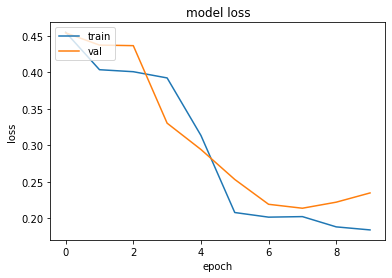

MessageError: ignored

<Figure size 432x288 with 0 Axes>

In [33]:
### PLOTTING ###
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(val_losses)

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()
from google.colab import files
plt.savefig("loss.png")
files.download("loss.png") 

In [0]:
### RUN THIS CELL ###
### THERE ARE TWO THINGS TO CHANGE IN THIS BLOCK, LOOK FOR THE ALL CAPS ###
from LSTM import LSTM
from RNN import RNN
import matplotlib.pyplot as plt
from google.colab import files
device = 'cuda'

### CHANGE THIS NEXT LINE TO WHATEVER YOUR DATASET NAME IS ###
dataset_name = '24_6'

# training parameters
num_epochs_list = [100] # pick 10, 50, 100
hidden_dim_list = [100] # pick 10, 50, 100
learning_rate_list = [.01] # pick .01, .001
networks = ['LSTM', 'RNN'] # run LSTM and RNN models

### CHANGE THIS NEXT LINE TO HOWEVER MANY MONTHS YOU'RE PREDICTING
months_to_predict = 6 # either 1, 3, or 6 depending on dataset

for num_epochs in num_epochs_list:
    for hidden_dim in hidden_dim_list:
        for learning_rate in learning_rate_list:
            for network in networks:
                model = None
                if network == 'LSTM':
                    model = LSTM(input_dim=235, hidden_dim=hidden_dim, output_dim=months_to_predict, num_layers=2)
                else:
                    model = RNN(D_in=235, H=hidden_dim, D_out=months_to_predict, L=1, dropout=0.0, device=device)
                if device is not None:
                    model.to(device)

                # set up optimizer, etc.
                loss_function = nn.MSELoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
                scheduler = ExponentialLR(optimizer, gamma=.95)

                train_losses = []
                val_losses = []
                
                # train
                print('training', end='')
                start_time = time.time()
                for i in range(num_epochs):
                    train_loss = train(model, train_loader, optimizer, loss_function, i+1, device=device)
                    train_losses += [train_loss]
                    val_loss = val(model, val_loader, loss_function, device=device)
                    val_losses += [val_loss]
                    scheduler.step()
                elapsed = time.time() - start_time
                print('\tTime Elapsed: {:.3f}s'.format(elapsed))
                
                # test
                print('testing ', end='')
                start_time = time.time()
                test_loss, test_mape = test(model, test_loader, loss_function, device=device)
                elapsed = time.time() - start_time
                print('\tTime Elapsed: {:.3f}s'.format(elapsed))

                # results
                print('RESULTS - epochs: {}\thidden_dim: {}\tlearning_rate: {}\tnetwork: {}\tRMSE: {:.6f}\tMAPE: {:.3f}%'.format(
                    num_epochs, hidden_dim, learning_rate, network, test_loss, test_mape))
                
                # plot
                print('plotting')
                plt.figure()
                plt.plot(train_losses)
                plt.plot(val_losses)
                plt.title('model loss')
                plt.ylabel('loss')
                plt.xlabel('epoch')
                plt.legend(['train','val'], loc='upper right')

                # save plot to drive
                filename = dataset_name + '_' + str(num_epochs) + '_' + str(hidden_dim) + '_' + str(int(1/learning_rate)) + '_' + network + '.png'
                filepath = 'drive/My Drive/DLPhotos/' + dataset_name + '/' + filename
                plt.savefig(filepath)
                plt.close()
                
                print()

training	Time Elapsed: 432.174s
testing 	Time Elapsed: 61.237s
RESULTS - epochs: 100	hidden_dim: 100	learning_rate: 0.01	network: LSTM	RMSE: 0.140524	MAPE: 14.641%
plotting

training	Time Elapsed: 782.436s
testing 	Time Elapsed: 234.315s
RESULTS - epochs: 100	hidden_dim: 100	learning_rate: 0.01	network: RNN	RMSE: 0.137684	MAPE: 14.054%
plotting

